In [74]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

A preliminary look at the data given shows that it is used for a method of decision-making classification algorithm known as C4.5. Hence every column of data available is a factor variable, which includes the price variable, which is merely categorised into "vigh, high, med, low". The class label in the original data set is the "acceptability" of the car, which is between "unacc, acc, good, vgood". The problem statement given is to predict the price given the class, and hence in this case we will be using the price as the class label, not the acceptability.

In [5]:
col_names = ['buying','maint','doors','persons','lug_boot','safety','accept']
df = pd.read_csv('car.data', names = col_names)

In [94]:
df.describe()

,buying,maint,doors,persons,lug_boot,safety,accept
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


The problem statement asks to predict the buying price given five variables, which includes all other columns other than `persons`.

Before building a model, let's do a bit of exploratory data analysis.

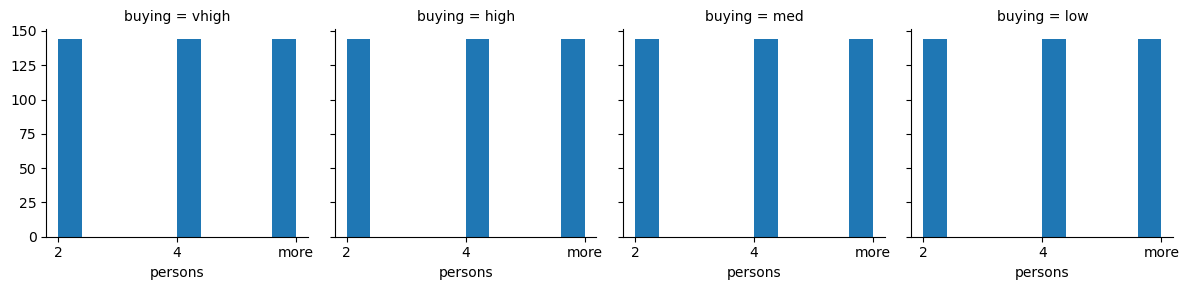

In [88]:
g = sns.FacetGrid(df, col='buying')
g.map(plt.hist, 'persons')

This tells us that, on the whole, the buying price isn't very much correlated to the number of doors on the car at all. Taken on its own, the number of doors has pretty much the same distribution over each of the possible categories of buying price. In fact, repeating this analysis shows basically the same occurring for each of the feature variables except `accept`:

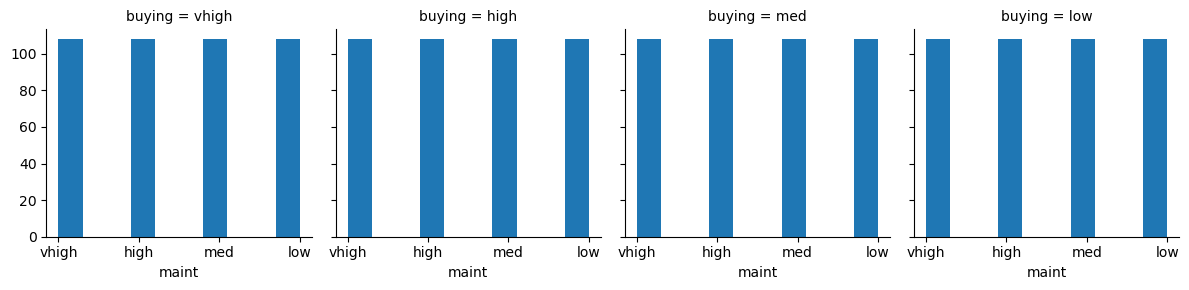

In [89]:
g = sns.FacetGrid(df, col='buying')
g.map(plt.hist, 'maint')

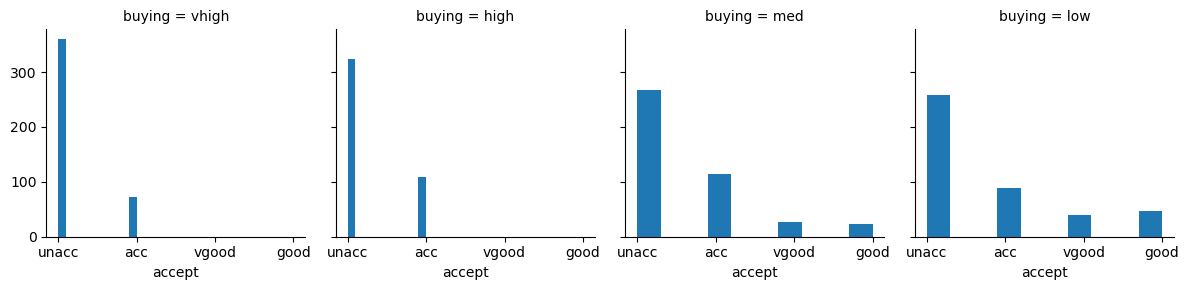

In [91]:
g = sns.FacetGrid(df, col='buying')
g.map(plt.hist, 'accept')

From this, we can see that `accept` is related to `buying` in the sense that a high buying price is much more strongly associated with unacceptability than a low buying price.

While the correlation of `buying` to the other variables is near nonexistent, would it be possible that trends emerge if paired with `accept`?

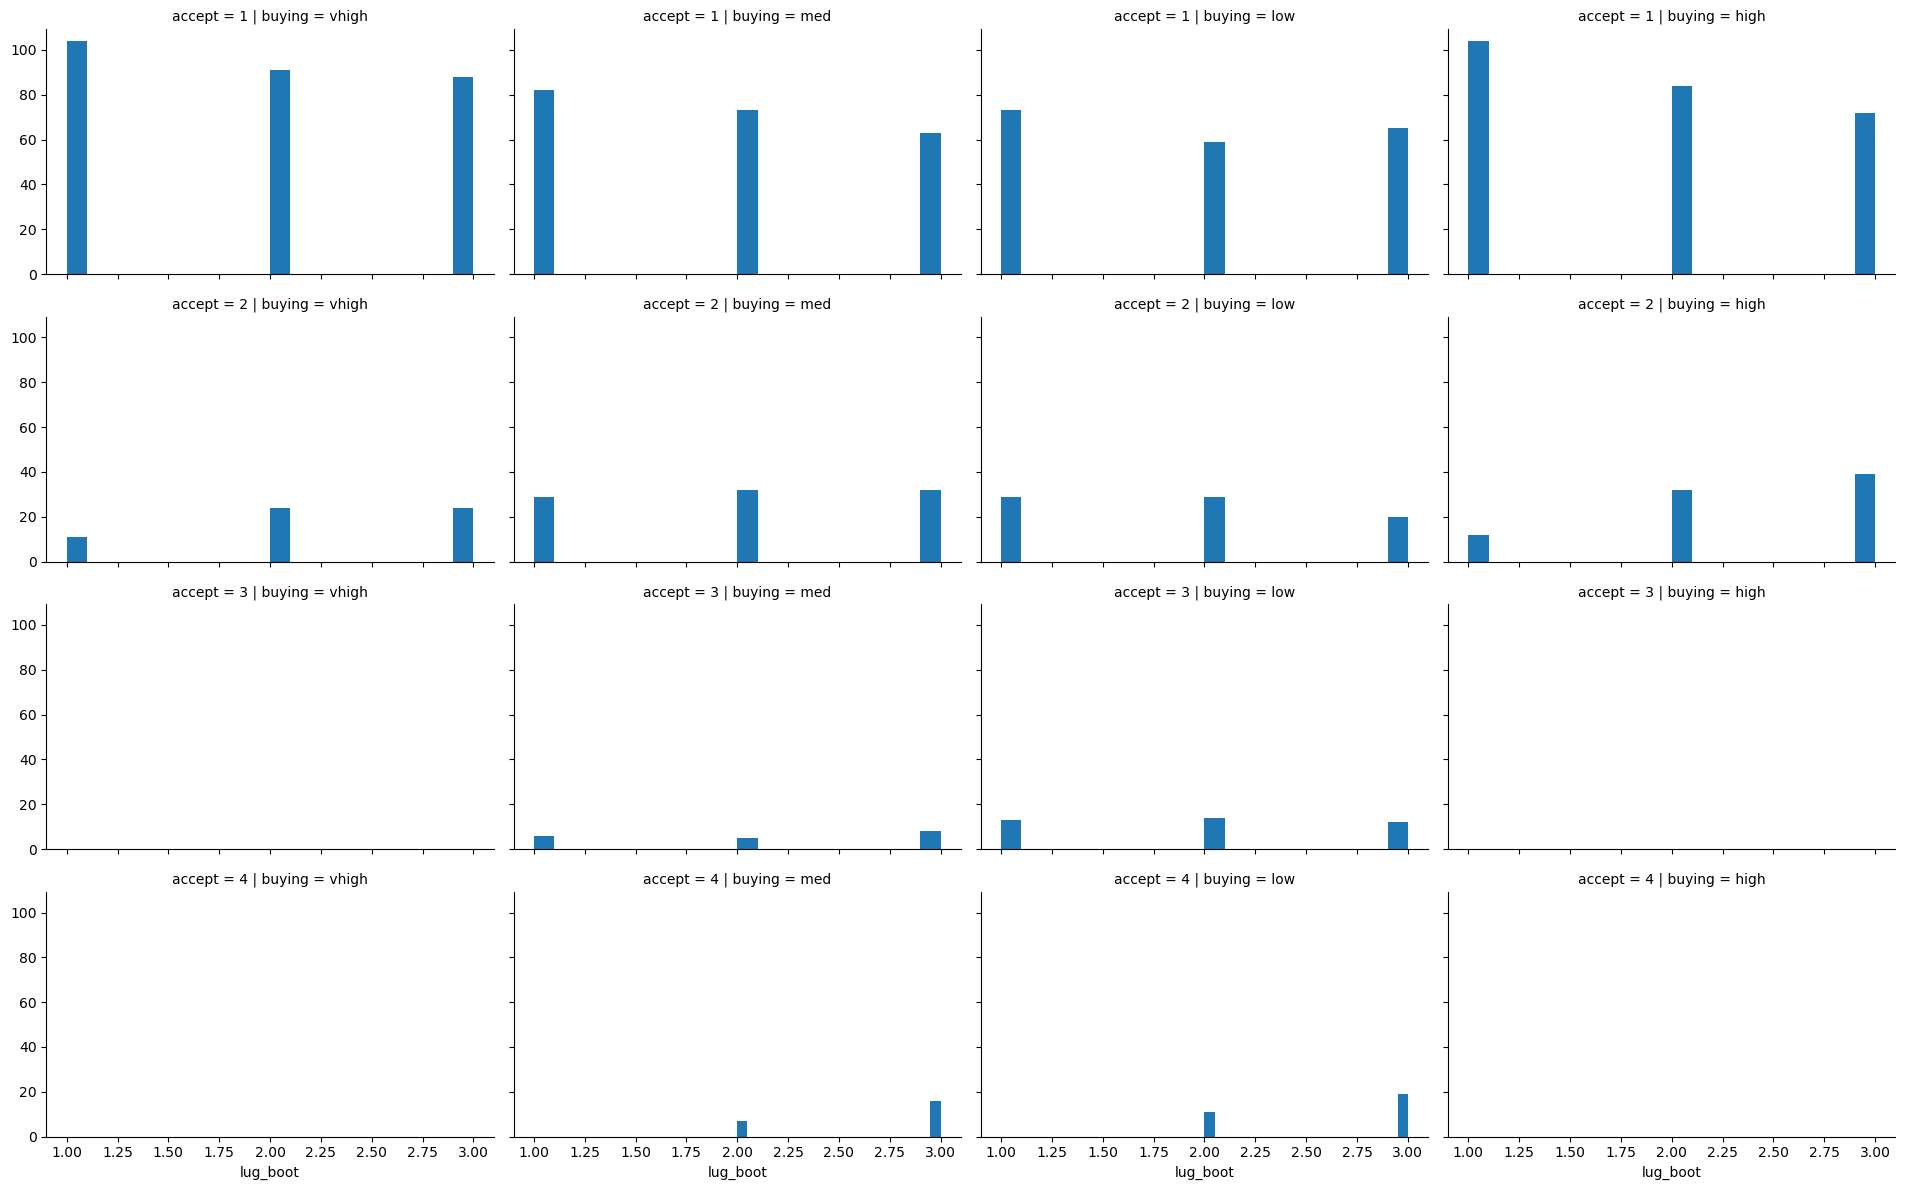

In [95]:
grid = sns.FacetGrid(train_df, col='buying', row='accept',  aspect=1.6)
grid.map(plt.hist, 'lug_boot',  bins=20)
grid.add_legend();

In fact, there does seem  to be a slight - although faint - variance in the distributions of `lug_boot` when split by both `accept` and `buying`. This does give hope that a predictive model can be made from the data.

Since the data itself is categorical, we can try to use sklearn's `DecisionTreeClassifier`.

In [10]:
# importing libraries

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 

In [81]:
feature_cols = ['maint','doors','lug_boot','safety','accept']
X = df[feature_cols]
y = df.buying

First of all, the `DecisionTreeClassifier` given by `sklearn` only allows analysis of numeric data, not categorical data. Hence we should first convert the data to numeric. It is convenient, then, that all of the data provided is ordinal; they come in a relationship that can be put on a scale. This means that, in order to preserve the meaning of e.g. "medium safety" being between "low" safety and "high" safety, we can convert each of the data points into integers.

In [82]:
maps = {'accept': {'unacc':1, 'acc':2, 'good':3, 'vgood':4},
'maint' : {'vhigh': 4, 'high': 3, 'med': 2, 'low': 1},
'doors': {'5more': 5, '4': 4, '3': 3, '2': 2},
'lug_boot': {'small': 1, 'med': 2, 'big':3},
'safety': {'low':1, 'med': 2, 'high':3}}

for colname in X.columns:
    X.loc[:,colname] = X[colname].map(maps[colname])


C:\Users\amphi\AppData\Local\Temp\ipykernel_25908\3663190980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,colname] = X[colname].map(maps[colname])
C:\Users\amphi\AppData\Local\Temp\ipykernel_25908\3663190980.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:,colname] = X[colname].map(maps[colname])
C:\Users\amphi\AppData\Local\Temp\ipykernel_25908\3663190980.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Next we split the data into training and test sets to test how good the model is after training it.

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 69) 

Building and testing the model:

In [97]:
classify_DTC = DecisionTreeClassifier().fit(X_train,y_train)
predictions_DTC = classify_DTC.predict(X_test)

In [98]:
metrics.accuracy_score(y_test, predictions_test)

0.12427745664739884

This is a pretty poor accuracy, presumably due to the loose correlation of most of the variables with `buying`. Let's see if we can improve it with a different algorithm.

In [104]:
from sklearn.ensemble import RandomForestClassifier
classify_RF = RandomForestClassifier(n_estimators = 10).fit(X_train,y_train)
predictions_RF = classify_RF.predict(X_test)

In [105]:
metrics.accuracy_score(y_test,predictions_RF)

0.1329479768786127

Despite using a stronger ensemble method that tries multiple random trees and finds the best-performing combinations of trees, the accuracy did not improve. A closer look at the data if sorted shows why this may be the case:

In [110]:
sorte = df.sort_values(['maint','doors','persons','lug_boot','safety','accept'])
sorte.head(20)

,buying,maint,doors,persons,lug_boot,safety,accept
116,vhigh,high,2,2,big,high,unacc
548,high,high,2,2,big,high,unacc
980,med,high,2,2,big,high,unacc
1412,low,high,2,2,big,high,unacc
114,vhigh,high,2,2,big,low,unacc
546,high,high,2,2,big,low,unacc
978,med,high,2,2,big,low,unacc
1410,low,high,2,2,big,low,unacc
115,vhigh,high,2,2,big,med,unacc
547,high,high,2,2,big,med,unacc


As it turns out, there's a single data point for each value of `buying` given each value of `maint`, `doors`,`persons`,`lug_boot`,`safety`. So there isn't much predictive power in those variables at all, if all of them have the same `accept` (and most samples in the data have `unacc` for their acceptability). `accept` has a strong correlation to price, however. So let's try to see if we can improve our score by reducing the features used:

In [113]:
X_train_2 = X_train[['accept']]
classify_DTC_2 = DecisionTreeClassifier().fit(X_train_2,y_train)
predictions_DTC_2 = classify_DTC_2.predict(X_test[['accept']])
metrics.accuracy_score(y_test,predictions_DTC_2)

0.33236994219653176

This seems to have a slightly better result. So, given the information provided, let's try to predict what the price would be if the class value was 'good':

In [114]:
classify_DTC_2.predict([[3]])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array(['low'], dtype=object)

It predicts a `low` price, which corresponds to earlier analysis that showed any `high` or `vhigh` price basically meant no possibility of a `good` or better classification.